In [122]:
import math
import numpy as np
from mpmath import mp as mpm
from mpmath import mpf
import matplotlib.pyplot as plt
mpm.dps = 6
mpm.pretty = True

In [123]:
def calculate_std_precision(n: int, alpha: float):
    result = np.zeros(n + 1)
    result[0] = math.log(1.0 + 1.0 / alpha)
    for i in range(1, n + 1):
        result[i] = 1.0/i - alpha*result[i - 1]
    return result

def calculate_mpf(n: int, alpha: float):
    result = mpm.zeros(1, n + 1)
    result[0] = mpm.log(1.0 + 1.0 / mpf(alpha))
    for i in range(1, n + 1):
        result[i] = 1.0/mpf(i) - mpf(alpha)*result[i - 1]
    return result

Let's investigate how standard precision algorithms handle the task

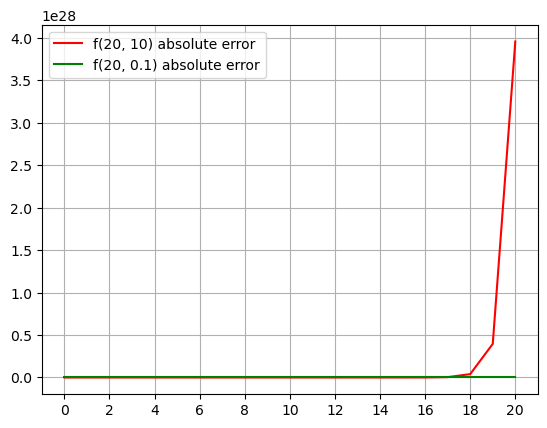

In [124]:
double_20_01 = calculate_std_precision(20, 0.1)
double_20_10 = calculate_std_precision(20, 10.0)
mpf_20_01 = np.array(calculate_mpf(20, 0.1))
mpf_20_10 = np.array(calculate_mpf(20, 10.0))
graph_x_axis = np.arange(21)

plt.xticks(range(0, 21, 2))
plt.plot(graph_x_axis,
         np.abs(mpf_20_10 - double_20_10) / np.finfo(float).eps,
         color='red',
         label='f(20, 10) absolute error')
plt.plot(graph_x_axis,
         np.abs(mpf_20_01 - double_20_01) / np.finfo(float).eps,
         color='green',
         label='f(20, 0.1) absolute error')
plt.grid(True)
plt.legend()
plt.show()

The solution for $f(20, 10)$ is woefully unstable, the error seems to grow exponentially with each new element of the sequence.

The relative error plots show that this instability leads to a considerable divergence with the exact result already at the tenth element.

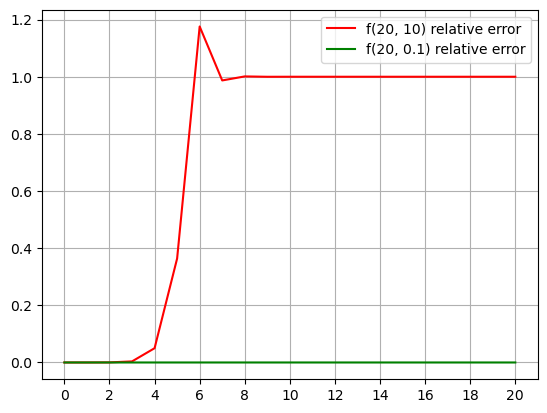

In [125]:
plt.xticks(range(0, 21, 2))
plt.plot(graph_x_axis,
         np.abs((mpf_20_10 - double_20_10) / mpf_20_10),
         color='red',
         label='f(20, 10) relative error')
plt.plot(graph_x_axis,
         np.abs((mpf_20_01 - double_20_01) / mpf_20_10),
         color='green',
         label='f(20, 0.1) relative error')
plt.grid(True)
plt.legend()
plt.show()

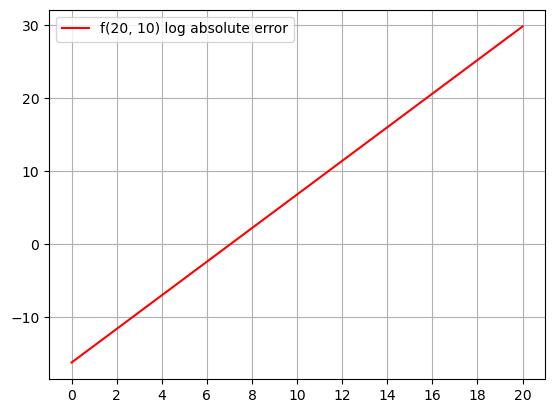

In [126]:
graph_y = np.log(np.array(np.abs(mpf_20_10 - double_20_10), dtype=np.float64))
plt.xticks(range(0, 21, 2))
plt.plot(graph_x_axis,
         graph_y,
         color='red',
         label='f(20, 10) log absolute error')
plt.grid(True)
plt.legend()
plt.show()

Logarithm of the error looks like a perfect linear function. We can use this fact to calculate corrections and apply them to the outputs of the floating point algorithm.

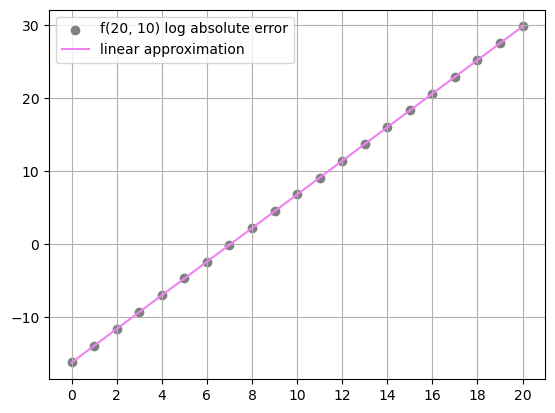

In [127]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a * x + b

optimal_params, _ = curve_fit(linear, graph_x_axis, graph_y, p0=[10.0, 2.25])

plt.xticks(range(0, 21, 2))
plt.scatter(graph_x_axis,
         graph_y,
         color='gray',
         label='f(20, 10) log absolute error')
plt.plot(graph_x_axis,
         linear(graph_x_axis, *optimal_params),
         color='violet',
         label='linear approximation')
plt.grid(True)
plt.legend()
plt.show()

In [128]:
scale_factor = np.exp(optimal_params[1])
exponent_factor = optimal_params[0]
def correction(x: np.ndarray) -> np.ndarray:
    signs = np.ones(x.shape[0])
    signs[::2] = -1.
    return signs * scale_factor * np.exp(exponent_factor * x)

def calculate_alpha_10(n: int) -> np.ndarray:
    alpha = 10.0
    result = np.zeros(n + 1)
    result[0] = math.log(1.0 + 1.0 / alpha)
    for i in range(1, n + 1):
        result[i] = 1.0/i - alpha*result[i - 1]
    return result + correction(np.arange(0, n + 1))

In [133]:
print(correction(np.arange(21)))
print(double_20_10 - mpf_20_10)

[-8.78218787e-08  8.78211777e-07 -8.78204768e-06  8.78197759e-05
 -8.78190750e-04  8.78183740e-03 -8.78176731e-02  8.78169722e-01
 -8.78162713e+00  8.78155704e+01 -8.78148695e+02  8.78141686e+03
 -8.78134678e+04  8.78127669e+05 -8.78120660e+06  8.78113652e+07
 -8.78106643e+08  8.78099635e+09 -8.78092626e+10  8.78085618e+11
 -8.78078609e+12]
[8.7832e-8 -8.7832e-7 8.7832e-6 -8.78121e-5 0.000878121 -0.0087812
 0.087812 -0.87812 8.7812 -87.812 878.12 -8781.2 87812.0 -878120.0
 8.7812e+6 -8.7812e+7 8.7812e+8 -8.7812e+9 8.7812e+10 -8.7812e+11
 8.7812e+12]


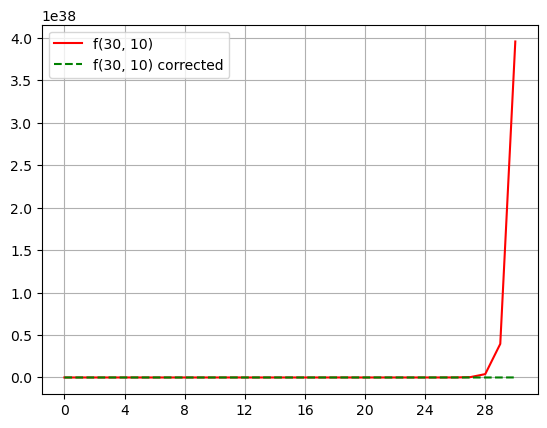

In [129]:
mpf_30_10 = np.array(calculate_mpf(30, 10.0))
double_30_10 = calculate_std_precision(30, 10.0)
corrected_30_10 = calculate_alpha_10(30)

graph2_x_axis = np.arange(0, 31)
plt.xticks(range(0, 31, 4))
plt.plot(graph2_x_axis,
         np.abs(mpf_30_10 - double_30_10) / np.finfo(float).eps,
         color='red',
         label='f(30, 10)')
plt.plot(graph2_x_axis,
         np.abs(mpf_30_10 - corrected_30_10) / np.finfo(float).eps,
         color='green',
         linestyle='--',
         label='f(30, 10) corrected')
plt.grid(True)
plt.legend()
plt.show()

The results of correction seem impressive when plotted against the simple algorithm results, but error still increases exponentially, albeit slower:

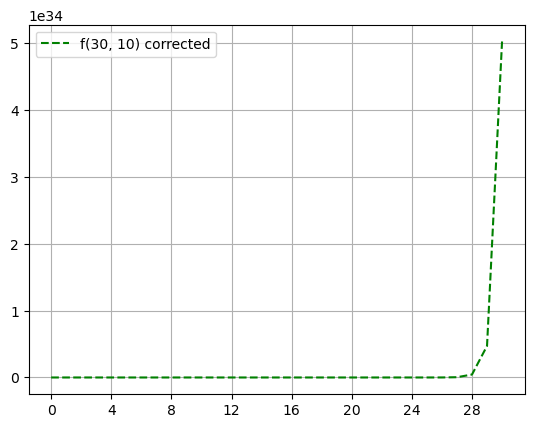

In [130]:
graph2_x_axis = np.arange(0, 31)
plt.xticks(range(0, 31, 4))
plt.plot(graph2_x_axis,
         np.abs(mpf_30_10 - corrected_30_10) / np.finfo(float).eps,
         color='green',
         linestyle='--',
         label='f(30, 10) corrected')
plt.grid(True)
plt.legend()
plt.show()

That behaviour should really be expected: the coefficients of the correction are themselves found with the finite precision and retain some error w.r.t. the exact values. This error grows exponentially with the correction. Perhaps we could continue adding new corrections until we end up with satisfactory precision, which in this case can be as good as $0.013\%$:

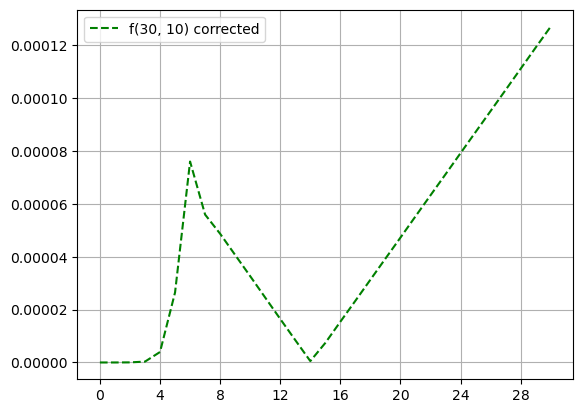

In [131]:
plt.xticks(range(0, 31, 4))
plt.plot(graph2_x_axis,
         np.abs((mpf_30_10 - corrected_30_10) / mpf_30_10),
         color='green',
         linestyle='--',
         label='f(30, 10) corrected')
plt.grid(True)
plt.legend()
plt.show()